In [19]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

In [20]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(1000))

valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)

In [22]:
select = ['max1', 'act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [23]:
criterion = TripletRegularizedMultiMarginLoss(0, .5)
sess = Session(model, criterion, optim.Adam, 1e-4)

In [24]:
validator = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy, 
                                    model_file="./no-reg.ckpt.tar")
lr_scheduler = CosAnneal(len(trainloader)*50, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [ ]:
sess.train(schedule, 50)

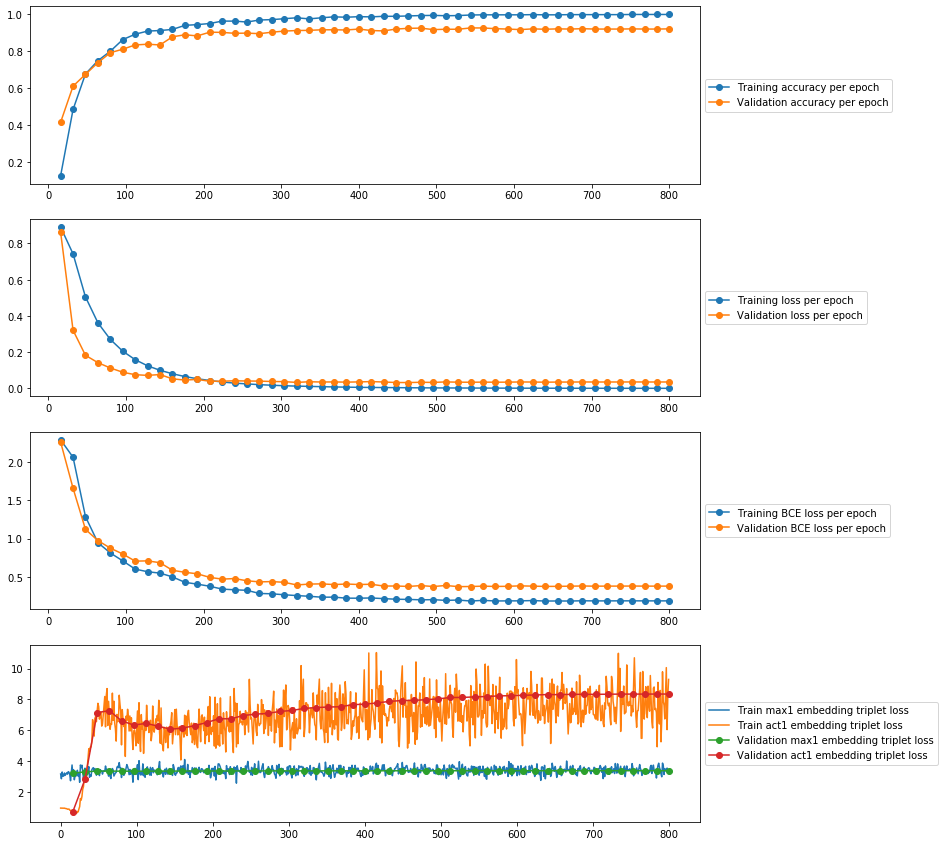

In [8]:
validator.plot()

In [ ]:
sess.load("./no-reg.ckpt.tar")

In [ ]:
total_valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
total_validator = EmbeddingSpaceValidator(total_valloader, len(select)-1, CustomOneHotAccuracy)

total_validator.run(sess)

In [ ]:
np.max(total_validator.val_accuracies), "Best accuracy without reg"

In [ ]:
visualization_set = torch.utils.data.dataset.Subset(valset, np.arange(500))
dataloader = torch.utils.data.DataLoader(visualization_set, batch_size=64, shuffle=False)

tensorboard_embeddings(model, ['max1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['max2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['max3'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['act1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['act2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['out'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')